In [157]:
from qiskit.circuit.library import XGate, YGate, ZGate, CU1Gate
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
import numpy as np
import random
from qiskit import transpile
from qiskit.primitives import Sampler
import matplotlib.pyplot as plt
from qiskit.visualization import plot_histogram
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_aer import AerSimulator

In [158]:
def noise_generator(alpha, beta, quantum_circuit):
    # Initialize a circuit with the same number of qubits and classical bits
    qc = QuantumCircuit(quantum_circuit.num_qubits, quantum_circuit.num_clbits)
    
    # Define noise channels
    noise_channels = [XGate(), YGate(), ZGate()]
    
    for instruction in quantum_circuit.data:
        # Get the qubit and classical bit indices
        qubit_indices = [quantum_circuit.find_bit(q).index for q in instruction.qubits]
        clbit_indices = [quantum_circuit.find_bit(c).index for c in instruction.clbits]
        
        # Apply the original gate in the new circuit with the same qubits and classical bits
        qc.append(instruction.operation, qubit_indices, clbit_indices)
        
        # Apply noise only to non-measurement gates
        if instruction.operation.name != 'measure':
            noise_gate = random.choice(noise_channels)
            random_number = np.random.rand()
            
            if instruction.operation.num_qubits == 1 and random_number < alpha:
                qc.append(noise_gate, [qubit_indices[0]])
            elif instruction.operation.num_qubits == 2 and random_number < beta:
                qc.append(noise_gate, [qubit_indices[1]])
    
    return qc


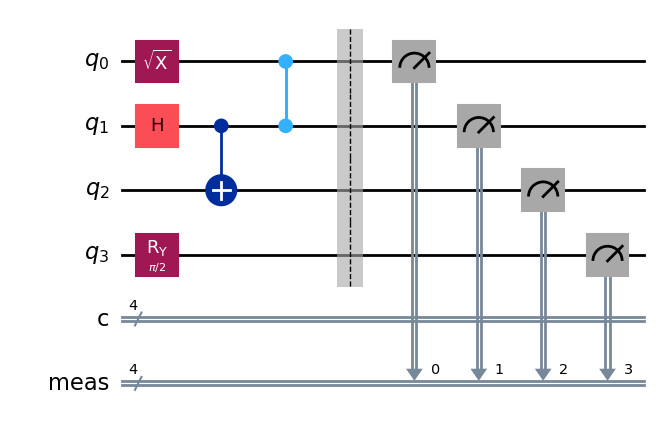

In [159]:
qr = 4
cr = 4
qc = QuantumCircuit(qr, cr)
qc.h(1)
qc.cx(1,2)
qc.sx(0)
qc.cz(0,1)
qc.ry(np.pi/2,3)
qc.measure_all()
qc.draw('mpl')

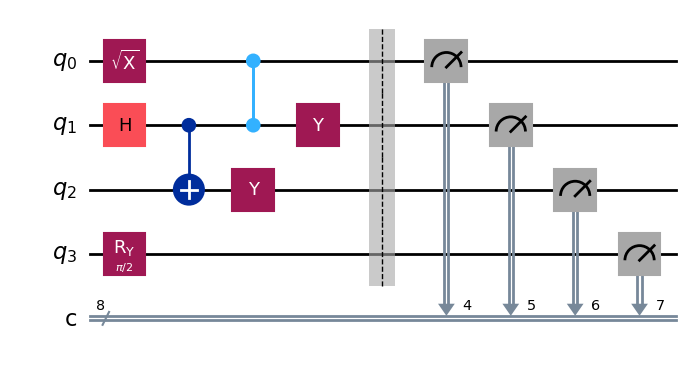

In [160]:
alpha = 0.5
beta = 0.5
noisy_circuit = noise_generator(alpha, beta, qc)
noisy_circuit.draw('mpl')

In [161]:
def circuit_decomposition(circuit):
    # Define the target basis gates
    target_basis = ['cx', 'id', 'rz', 'sx', 'x']
    
    # Transpile the circuit to the target basis
    decomposed_circuit = transpile(circuit, basis_gates=target_basis)
    
    return decomposed_circuit

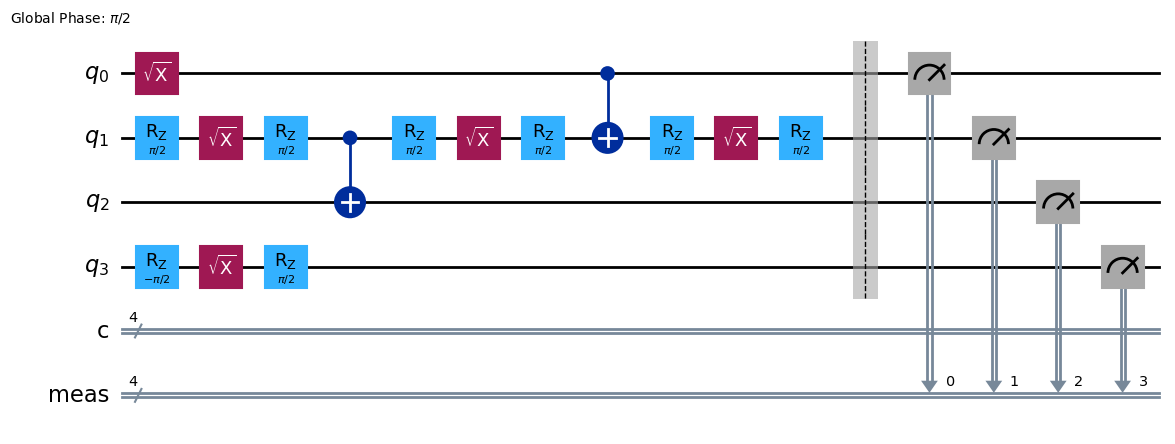

In [162]:
dc = circuit_decomposition(qc)
dc.draw('mpl')

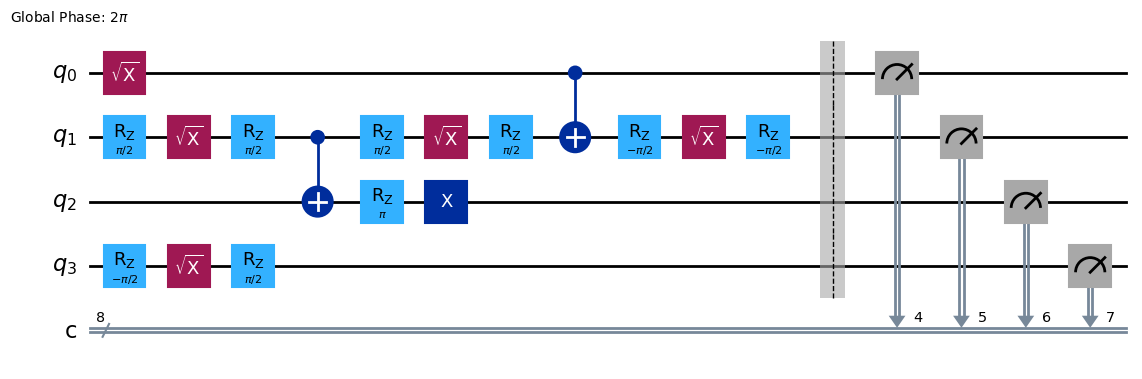

In [163]:
dnc = circuit_decomposition(noisy_circuit)
dnc.draw('mpl')

In [164]:
# Function transforming two number a and b into their binary representation
def int_to_binary(a, b):
    bin_a = bin(a)[2:]
    bin_b = bin(b)[2:]
    l = max(len(bin_a), len(bin_b))
    binary_a = bin_a.zfill(l)
    binary_b = bin_b.zfill(l)
    return binary_a, binary_b

# Function transforming a binary number into its integer representation
def binary_to_int(binary_a):
    return int(binary_a, 2)


def qft(qc):
    n = qc.num_qubits
    for j in range(n):
        qc.h(j)
        for k in range(j+1, n):
            theta = 2*np.pi/ 2**(k-j+1)
            qc.append(CU1Gate(theta), [k,j])
        qc.barrier()
    return qc

def iqft(qc, q_list):
    n = len(q_list)
    for j in range(n):
        qc.h(q_list[j])
        for k in range(j+1, n):
            theta = -2*np.pi/ 2**(k-j+1)
            qc.append(CU1Gate(theta), [q_list[k],q_list[j]])
        qc.barrier()
    return qc

# Function encoding the second binary number inside a quantum circuit.
def b_circuit(binary_b):
    n = len(binary_b)
    bc = QuantumCircuit(n)
    # Apply the X gate to qubits where binary_x has '1'
    for i in range(n):
        if binary_b[i] == '1':
            bc.x(i)  # Apply X gate to the ith qubit
    bc.barrier()
    return bc

# Function encoding the first binary number inside a quantum circuit.
def a_circuit(binary_a):
    n = len(binary_a)
    ac = QuantumCircuit(n+1, n+1)
    # Apply the X gate to qubits where binary_x has '1'
    for i in range(n):
        if binary_a[i] == '1':
            ac.x(i+1)  # Apply X gate to the ith qubit
    ac.barrier()
    return ac

def quantum_sum(qc_b, qc_a):
    na = qc_a.num_qubits
    nb = qc_b.num_qubits

    # Apply QFT to the second circuit encoding the number a.
    qft(qc_a)

    # Compose the two circuits encoding the two binary numbers.
    q_sum_circuit = QuantumCircuit(nb+na, na)
    q_sum_circuit.compose(qc_b, qubits = list(range(nb)), inplace=True)
    # q_sum_circuit.compose(qc_a, qubits = list(range(nb, nb+na)), inplace=True)
    q_sum_circuit.compose(qc_a, qubits = list(range(nb,nb + na )), inplace=True)

    # Apply the phase step indicated in Draper's algorithm.
    for s in range(nb, nb+na):
        for j in range(nb):
            if (j+nb-s+2) > 0:
                theta = 2*np.pi/ 2**(j+nb-s+2)
                q_sum_circuit.append(CU1Gate(theta), [j,s])
            else:
                pass
        q_sum_circuit.barrier()

    q_sum_circuit = iqft(q_sum_circuit, list(range(nb+na-1, nb-1, -1)))

    q_sum_circuit.measure(list(range(nb+na-1,nb-1,-1)),list(range(na)))
    return q_sum_circuit

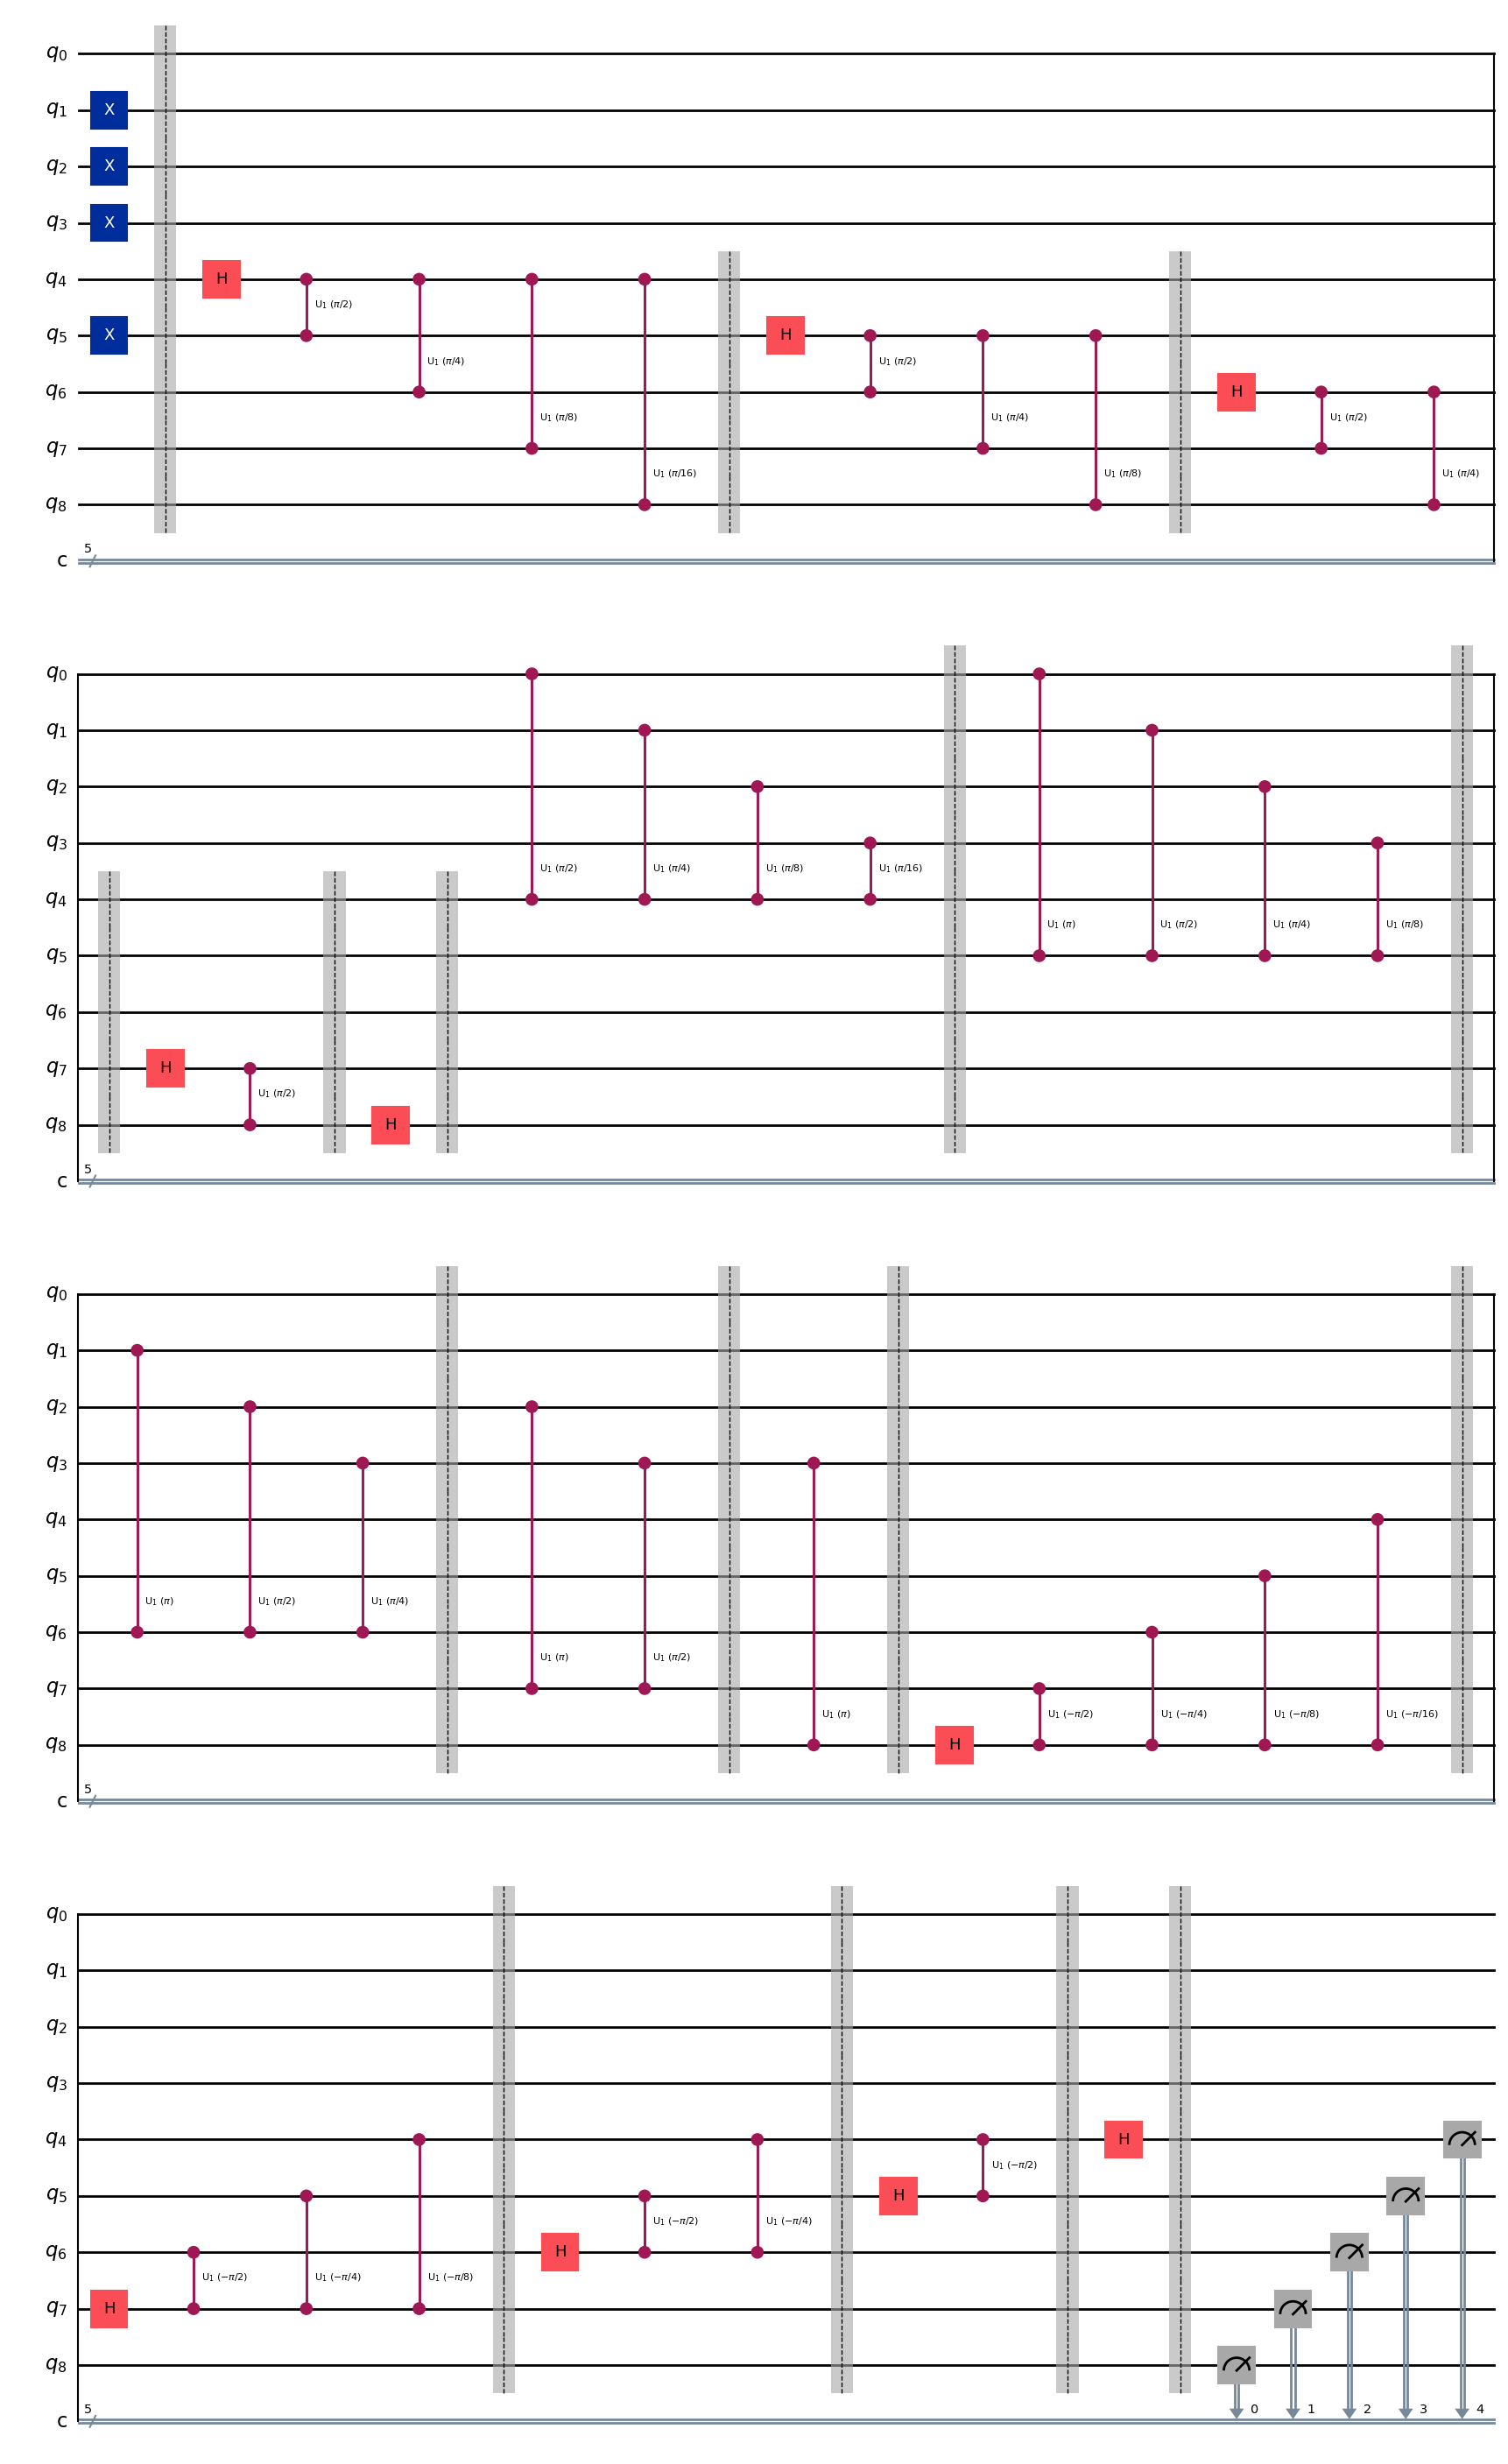

In [202]:
# Now we verify the results of the quantum_sum function. Try with different values of x and y, definitely it works!
x = 8
y = 7
a,b = int_to_binary(x,y)
first_circuit = b_circuit(b)
second_circuit = a_circuit(a)

final_circuit = quantum_sum(first_circuit, second_circuit)
final_circuit.draw('mpl')

Key with max value: 15
Max value: 1.0


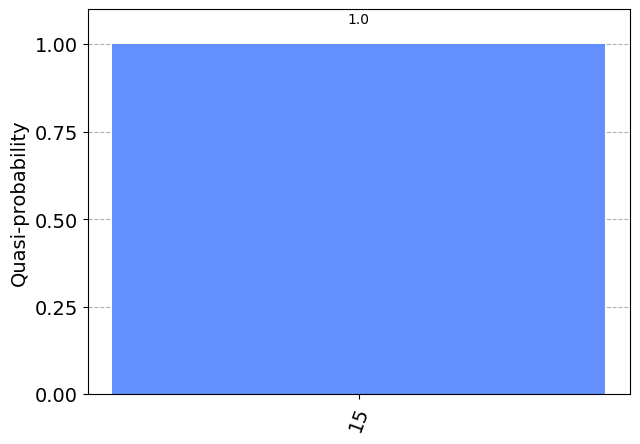

In [203]:
sampler = Sampler()
job = sampler.run(final_circuit, shots=2000)
result = job.result()
qs = result.quasi_dists[0]
max_key, max_value = max(qs.items(), key=lambda item: item[1])
print("Key with max value:", max_key)
print("Max value:", max_value)
plot_histogram(qs)

In [204]:
dc_success_rate_dic = {}

alphas = [x * 0.02 for x in range(11)]
betas = [x * 0.02 for x in range(11)]

# Calculating the success rate for the decomposed circuit
decomposed_final_circuit = circuit_decomposition(final_circuit)
for alpha in alphas:
    for beta in betas:
        noisy_decomposed_circuit = noise_generator(alpha, beta, decomposed_final_circuit)
        job = sampler.run(noisy_decomposed_circuit, shots=2000)
        result = job.result()
        qs = result.quasi_dists[0]
        if x+y in qs.keys():
            success_rate = qs[x+y]
        else:
            success_rate = 0
        dc_success_rate_dic[(alpha,beta)] = success_rate

# Calculating the success rate for the un-decomposed circuit
uc_success_rate_dic = {}
for alpha in alphas:
    for beta in betas:
        noisy_circuit = noise_generator(alpha, beta, final_circuit)
        job2 = sampler.run(noisy_circuit, shots=2000)
        result2 = job2.result()
        qs2 = result2.quasi_dists[0]
        if x+y in qs2.keys():
            success_rate = qs2[x+y]
        else:
            success_rate = 0
        uc_success_rate_dic[(alpha,beta)] = success_rate


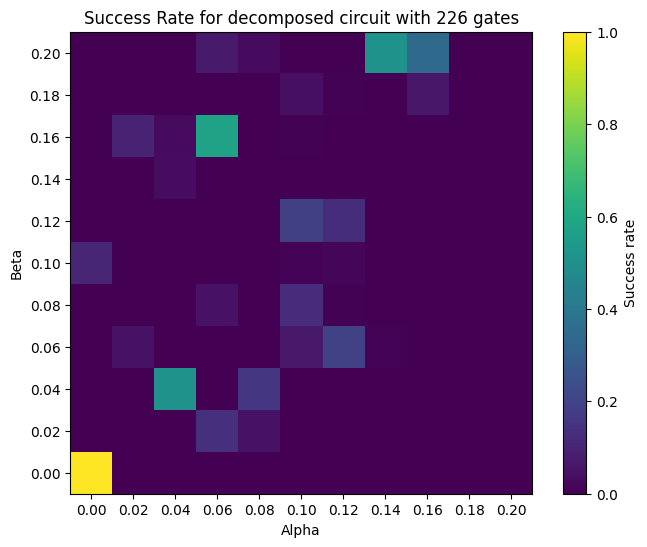

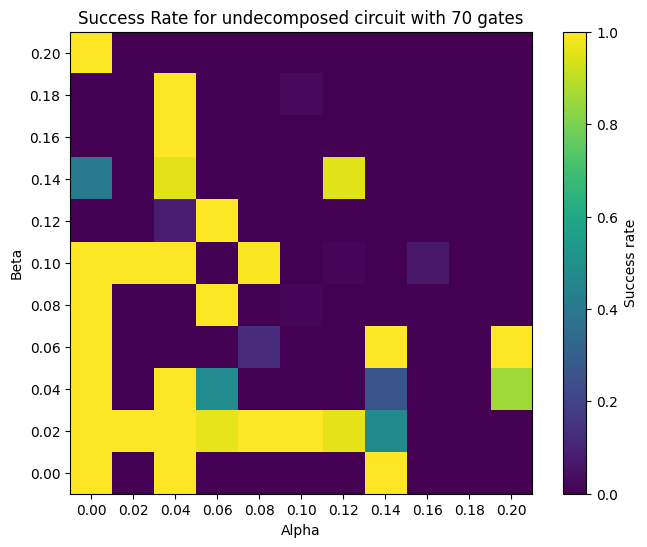

In [205]:
data=[dc_success_rate_dic, uc_success_rate_dic]

number_of_gates= [len(decomposed_final_circuit.data), len(final_circuit.data)]

circuit_description = ['decomposed', 'undecomposed']

for data, n, description in zip(data, number_of_gates, circuit_description):
    # Extract unique x and y coordinates
    x_coords = sorted(set(key[0] for key in data.keys()))
    y_coords = sorted(set(key[1] for key in data.keys()))
    
    # Create a matrix to hold the data
    heatmap_data = np.zeros((len(x_coords), len(y_coords)))
    
    # Fill the matrix with values from the dictionary
    for (x, y), value in data.items():
        x_i = x_coords.index(x)
        y_i = y_coords.index(y)
        heatmap_data[x_i, y_i] = value
    
    # Plot the heatmap
    plt.figure(figsize=(8, 6))
    plt.imshow(heatmap_data, origin='lower', cmap='viridis', interpolation='nearest')
    plt.colorbar(label='Success rate')
    
    # Set axis labels and ticks
    plt.xticks(ticks=np.arange(len(y_coords)), labels=[f"{y:.2f}" for y in y_coords])
    plt.yticks(ticks=np.arange(len(x_coords)), labels=[f"{x:.2f}" for x in x_coords])
    plt.xlabel('Alpha')
    plt.ylabel('Beta')
    plt.title(f'Success Rate for {description} circuit with {n} gates')
    
    plt.show()

As shown by the figure, the success rate is significantly reduced by increasing the number of gates. Furthermore, the success rate is approximately null for alpha and beta > 0.1 for the 70-gates circuit. For the 226-gates circuit, the success rate is reduced more heavily by noise. One can decrease the effect of noise by using error-correction codes but that will heavily increase the overhead of computations. A better option would be using error-mitigation techniques like PEC, ZNE, etc.